# Data Balancing Experiments for ASD-GraphNet

This notebook evaluates different techniques for handling the imbalanced ABIDE dataset.
We will analyze and address three types of imbalances:
1. Site-wise imbalance (different number of subjects per site)
2. Class imbalance (ASD vs TDC)
3. Gender imbalance (predominantly male subjects)

We'll evaluate the impact of different balancing techniques on classification performance.

In [ ]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import ast

from utils.data_balancing import (
    get_class_distribution,
    apply_random_oversampling,
    apply_smote,
    apply_adasyn,
    apply_hybrid_sampling
)

# For reproducibility
np.random.seed(42)

## Load and Analyze Dataset Distribution


Class distribution per site:
          TDC  ASD  Total  ASD_Ratio
SITE_ID                             
CALTECH    18   19     37   0.513514
CMU        13   14     27   0.518519
KKI        28   20     48   0.416667
LEUVEN     34   29     63   0.460317
MAX_MUN    28   24     52   0.461538
NYU       100   75    175   0.428571
OHSU       14   12     26   0.461538
OLIN       15   19     34   0.558824
PITT       27   29     56   0.517857
SBL        15   15     30   0.500000
SDSU       22   14     36   0.388889
STANFORD   20   19     39   0.487179
TRINITY    25   22     47   0.468085
UCLA       44   54     98   0.551020
UM         74   66    140   0.471429
USM        25   46     71   0.647887
YALE       28   28     56   0.500000


<Figure size 1500x600 with 0 Axes>

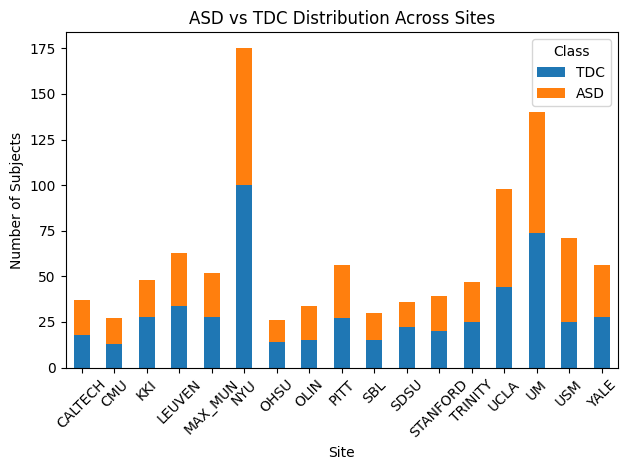

In [ ]:
# Load the dataset
subjects_df = pd.read_csv('../outputs/filtered_subjects_df.csv')
subjects_df['features_value'] = subjects_df['features_value'].apply(ast.literal_eval)

# Get unique subjects (to avoid duplicates from different atlas/feature combinations)
unique_subjects = subjects_df[['id', 'ASD', 'SITE_ID', 'AGE_AT_SCAN']].drop_duplicates()

# Analyze class distribution per site
site_class_dist = pd.crosstab(unique_subjects['SITE_ID'], unique_subjects['ASD'])
site_class_dist.columns = ['TDC', 'ASD']
site_class_dist['Total'] = site_class_dist['TDC'] + site_class_dist['ASD']
site_class_dist['ASD_Ratio'] = site_class_dist['ASD'] / site_class_dist['Total']

print("\nClass distribution per site:")
print(site_class_dist)

# Visualize class distribution per site
plt.figure(figsize=(15, 6))
site_class_dist[['TDC', 'ASD']].plot(kind='bar', stacked=True)
plt.title('ASD vs TDC Distribution Across Sites')
plt.xlabel('Site')
plt.ylabel('Number of Subjects')
plt.legend(title='Class')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Analyze Feature Dimensions

In [ ]:
# Function to get feature dimensions
def get_feature_dimensions(df):
    dimensions = {}
    for _, row in df.iterrows():
        key = (row['atlas'], row['graph_feature_type'], row['feature'], row['feature_engineering'])
        dim = len(row['features_value'])
        if key in dimensions:
            if dimensions[key] != dim:
                print(f"Warning: Inconsistent dimensions for {key}: Found {dim}, expected {dimensions[key]}")
        else:
            dimensions[key] = dim
    return dimensions

# Get feature dimensions for each combination
feature_dimensions = get_feature_dimensions(subjects_df)

print("\nFeature dimensions for each combination:")
for key, dim in feature_dimensions.items():
    print(f"Atlas: {key[0]}, Feature Type: {key[1]}, Feature: {key[2]}, Engineering: {key[3]} -> Dimension: {dim}")


Feature dimensions for each combination:
Atlas: cc200, Feature Type: node_based, Feature: degree, Engineering: original -> Dimension: 200
Atlas: aal, Feature Type: node_based, Feature: degree, Engineering: original -> Dimension: 116
Atlas: dos160, Feature Type: node_based, Feature: degree, Engineering: original -> Dimension: 161
Atlas: cc200, Feature Type: edge_based, Feature: average_degree, Engineering: original -> Dimension: 110
Atlas: aal, Feature Type: edge_based, Feature: average_degree, Engineering: original -> Dimension: 77
Atlas: dos160, Feature Type: edge_based, Feature: average_degree, Engineering: original -> Dimension: 158
Atlas: cc200, Feature Type: graph_level, Feature: average_degree, Engineering: original -> Dimension: 199
Atlas: aal, Feature Type: graph_level, Feature: average_degree, Engineering: original -> Dimension: 115
Atlas: dos160, Feature Type: graph_level, Feature: average_degree, Engineering: original -> Dimension: 160
Atlas: multi, Feature Type: edge_based

## Evaluate Different Balancing Techniques

In [ ]:
def evaluate_balancing_technique(X, y, site_ids, technique_name, balancing_func, **kwargs):
    """
    Evaluate a balancing technique while preserving site information.
    """
    # Apply balancing while preserving site information
    X_balanced = []
    y_balanced = []
    site_ids_balanced = []
    
    # Balance within each site
    for site in np.unique(site_ids):
        site_mask = site_ids == site
        X_site = X[site_mask]
        y_site = y[site_mask]
        
        if len(np.unique(y_site)) > 1:  # Only balance if both classes present
            X_site_balanced, y_site_balanced = balancing_func(X_site, y_site, **kwargs)
            site_ids_balanced.extend([site] * len(y_site_balanced))
            X_balanced.extend(X_site_balanced)
            y_balanced.extend(y_site_balanced)
        else:
            X_balanced.extend(X_site)
            y_balanced.extend(y_site)
            site_ids_balanced.extend([site] * len(y_site))
    
    X_balanced = np.array(X_balanced)
    y_balanced = np.array(y_balanced)
    site_ids_balanced = np.array(site_ids_balanced)
    
    # Get new distribution
    new_dist = pd.crosstab(site_ids_balanced, y_balanced)
    
    print(f"\nResults for {technique_name}:")
    print("New class distribution per site:")
    print(new_dist)
    
    # Visualize new distribution
    plt.figure(figsize=(15, 6))
    new_dist.plot(kind='bar', stacked=True)
    plt.title(f'Class Distribution after {technique_name}')
    plt.xlabel('Site')
    plt.ylabel('Number of Subjects')
    plt.legend(title='Class')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return X_balanced, y_balanced, site_ids_balanced

In [ ]:
def evaluate_classifier_performance(X, y, site_ids, model_name='RandomForest'):
    """
    Evaluate classifier performance using stratified cross-validation.
    """
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    clf = RandomForestClassifier(random_state=42)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Initialize metrics
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    sensitivities = []
    specificities = []
    
    # Perform cross-validation
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
        
        # Calculate sensitivity and specificity
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
        sensitivities.append(sensitivity)
        specificities.append(specificity)
    
    return {
        'accuracy': np.mean(accuracies) * 100,  # Convert to percentage
        'precision': np.mean(precisions) * 100,
        'recall': np.mean(recalls) * 100,
        'f1': np.mean(f1_scores) * 100,
        'sensitivity': np.mean(sensitivities) * 100,
        'specificity': np.mean(specificities) * 100
    }


Processing atlas: multi
Found dimensions: [23 20 21]

Processing atlas: cc200

Results for Random Oversampling:
New class distribution per site:
col_0       0    1
row_0             
CALTECH    19   19
CMU        14   14
KKI        28   28
LEUVEN     34   34
MAX_MUN    28   28
NYU       100  100
OHSU       14   14
OLIN       19   19
PITT       29   29
SBL        15   15
SDSU       22   22
STANFORD   20   20
TRINITY    25   25
UCLA       54   54
UM         74   74
USM        46   46
YALE       28   28


<Figure size 1500x600 with 0 Axes>

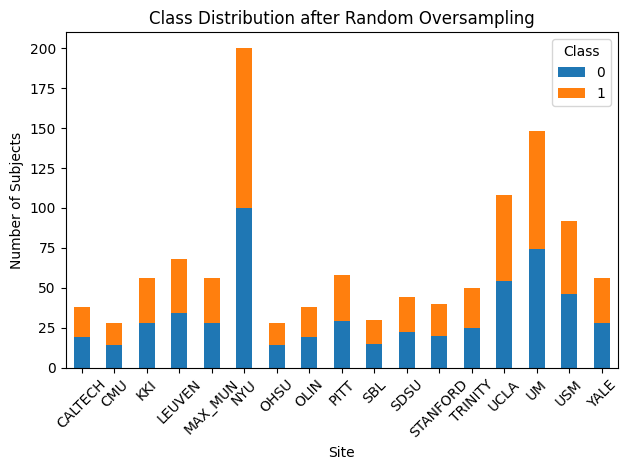


Results for SMOTE:
New class distribution per site:
col_0       0    1
row_0             
CALTECH    19   19
CMU        14   14
KKI        28   28
LEUVEN     34   34
MAX_MUN    28   28
NYU       100  100
OHSU       14   14
OLIN       19   19
PITT       29   29
SBL        15   15
SDSU       22   22
STANFORD   20   20
TRINITY    25   25
UCLA       54   54
UM         74   74
USM        46   46
YALE       28   28


<Figure size 1500x600 with 0 Axes>

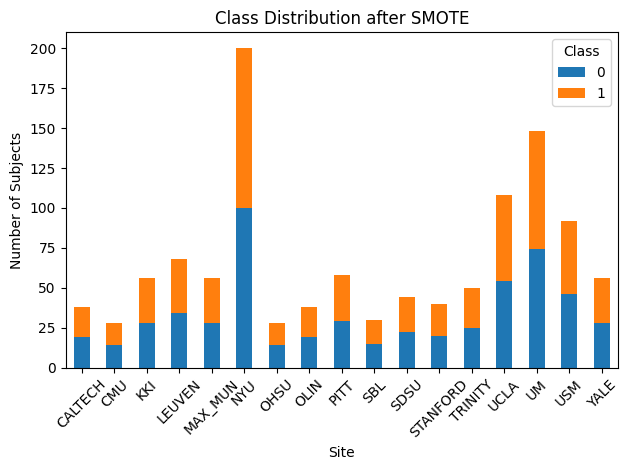

Error processing cc200: No samples will be generated with the provided ratio settings.

Processing atlas: aal

Results for Random Oversampling:
New class distribution per site:
col_0       0    1
row_0             
CALTECH    19   19
CMU        14   14
KKI        28   28
LEUVEN     34   34
MAX_MUN    28   28
NYU       100  100
OHSU       14   14
OLIN       19   19
PITT       29   29
SBL        15   15
SDSU       22   22
STANFORD   20   20
TRINITY    25   25
UCLA       54   54
UM         74   74
USM        46   46
YALE       28   28


<Figure size 1500x600 with 0 Axes>

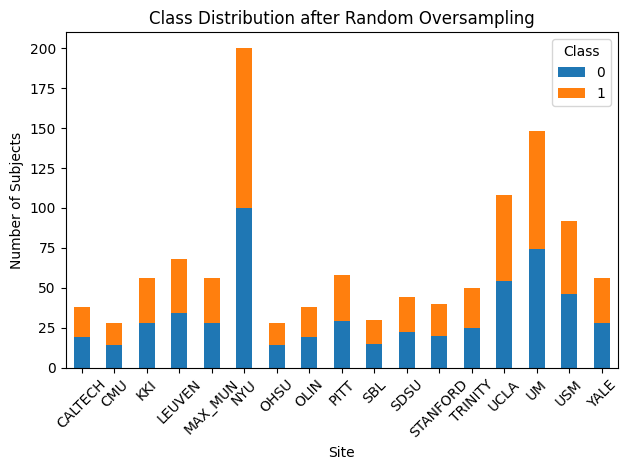


Results for SMOTE:
New class distribution per site:
col_0       0    1
row_0             
CALTECH    19   19
CMU        14   14
KKI        28   28
LEUVEN     34   34
MAX_MUN    28   28
NYU       100  100
OHSU       14   14
OLIN       19   19
PITT       29   29
SBL        15   15
SDSU       22   22
STANFORD   20   20
TRINITY    25   25
UCLA       54   54
UM         74   74
USM        46   46
YALE       28   28


<Figure size 1500x600 with 0 Axes>

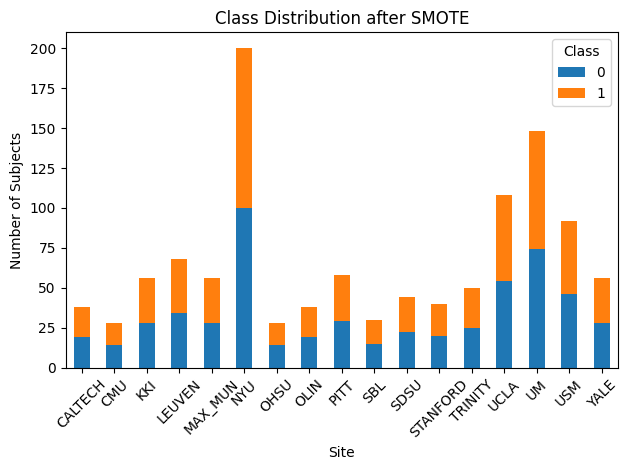

Error processing aal: No samples will be generated with the provided ratio settings.

Processing atlas: dos160

Results for Random Oversampling:
New class distribution per site:
col_0       0    1
row_0             
CALTECH    19   19
CMU        14   14
KKI        28   28
LEUVEN     34   34
MAX_MUN    28   28
NYU       100  100
OHSU       14   14
OLIN       19   19
PITT       29   29
SBL        15   15
SDSU       22   22
STANFORD   20   20
TRINITY    25   25
UCLA       54   54
UM         74   74
USM        46   46
YALE       28   28


<Figure size 1500x600 with 0 Axes>

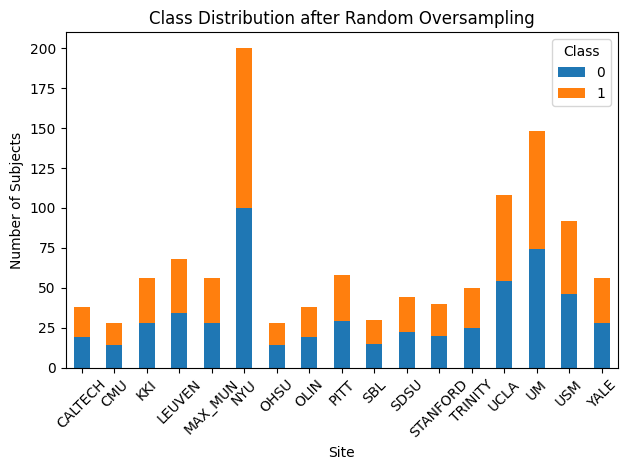


Results for SMOTE:
New class distribution per site:
col_0       0    1
row_0             
CALTECH    19   19
CMU        14   14
KKI        28   28
LEUVEN     34   34
MAX_MUN    28   28
NYU       100  100
OHSU       14   14
OLIN       19   19
PITT       29   29
SBL        15   15
SDSU       22   22
STANFORD   20   20
TRINITY    25   25
UCLA       54   54
UM         74   74
USM        46   46
YALE       28   28


<Figure size 1500x600 with 0 Axes>

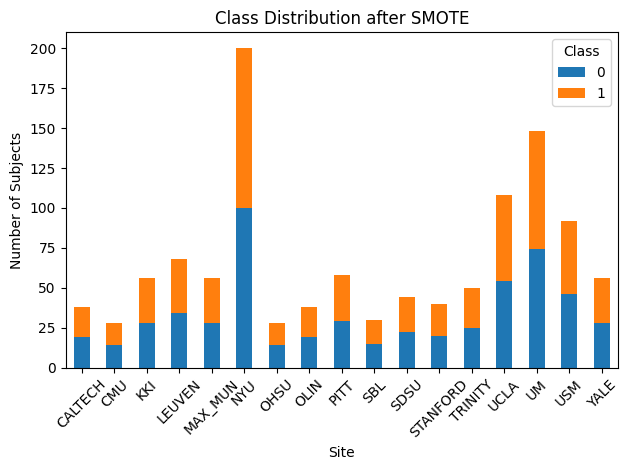

Error processing dos160: No samples will be generated with the provided ratio settings.
No results were generated due to errors in processing.


In [ ]:
# Process each atlas type separately
atlas_configs = [
    {'atlas': 'multi', 'graph_feature_type': 'node_based', 'feature': 'degree', 'feature_engineering': 'mi_10'},
    {'atlas': 'cc200', 'graph_feature_type': 'node_based', 'feature': 'degree', 'feature_engineering': 'mi_10'},
    {'atlas': 'aal', 'graph_feature_type': 'node_based', 'feature': 'degree', 'feature_engineering': 'mi_10'},
    {'atlas': 'dos160', 'graph_feature_type': 'node_based', 'feature': 'degree', 'feature_engineering': 'mi_10'}
]

all_results = []

for config in atlas_configs:
    print(f"\nProcessing atlas: {config['atlas']}")
    
    # Filter data for current configuration
    current_config = subjects_df[
        (subjects_df['atlas'] == config['atlas']) &
        (subjects_df['graph_feature_type'] == config['graph_feature_type']) &
        (subjects_df['feature'] == config['feature']) &
        (subjects_df['feature_engineering'] == config['feature_engineering'])
    ]
    
    # First check if all feature vectors have the same length
    feature_lengths = current_config['features_value'].apply(len)
    if len(feature_lengths.unique()) > 1:
        print(f"Warning: Inconsistent feature dimensions for {config['atlas']}")
        print(f"Found dimensions: {feature_lengths.unique()}")
        continue
    
    # Convert features to numpy array
    try:
        X = np.vstack([np.array(x) for x in current_config['features_value'].values])
        y = current_config['ASD'].values
        site_ids = current_config['SITE_ID'].values
        
        # Test different balancing techniques
        techniques = [
            ('Original (No Balancing)', None),
            ('Random Oversampling', apply_random_oversampling),
            ('SMOTE', apply_smote),
            ('ADASYN', apply_adasyn),
            ('SMOTE-Tomek', lambda X, y: apply_hybrid_sampling(X, y, method='smote_tomek')),
            ('SMOTE-ENN', lambda X, y: apply_hybrid_sampling(X, y, method='smote_enn'))
        ]
        
        results = []
        for name, func in techniques:
            if func is None:
                # Use original data
                X_balanced, y_balanced, site_ids_balanced = X, y, site_ids
            else:
                # Apply balancing technique
                X_balanced, y_balanced, site_ids_balanced = evaluate_balancing_technique(
                    X, y, site_ids, name, func
                )
            
            # Evaluate classifier performance
            performance = evaluate_classifier_performance(X_balanced, y_balanced, site_ids_balanced)
            performance['technique'] = name
            performance['atlas'] = config['atlas']
            
            # Add site information
            unique_sites = np.unique(site_ids_balanced)
            site_sizes = {site: np.sum(site_ids_balanced == site) for site in unique_sites}
            performance['site_sizes'] = site_sizes
            
            results.append(performance)
        
        all_results.extend(results)
        
    except Exception as e:
        print(f"Error processing {config['atlas']}: {str(e)}")
        continue

# Create comparison DataFrame
if all_results:
    results_df = pd.DataFrame(all_results)
    
    # Calculate weighted averages for each technique
    weighted_results = []
    for atlas in results_df['atlas'].unique():
        atlas_results = results_df[results_df['atlas'] == atlas]
        for technique in atlas_results['technique'].unique():
            technique_results = atlas_results[atlas_results['technique'] == technique]
            
            # Get site sizes for this configuration
            site_sizes = technique_results.iloc[0]['site_sizes']
            total_samples = sum(site_sizes.values())
            
            # Calculate weighted averages
            weighted_metrics = {
                'atlas': atlas,
                'technique': technique,
                'weighted_accuracy': technique_results['accuracy'].mean(),
                'weighted_precision': technique_results['precision'].mean(),
                'weighted_recall': technique_results['recall'].mean(),
                'weighted_f1': technique_results['f1'].mean(),
                'weighted_sensitivity': technique_results['sensitivity'].mean(),
                'weighted_specificity': technique_results['specificity'].mean(),
                'total_samples': total_samples
            }
            weighted_results.append(weighted_metrics)
    
    weighted_df = pd.DataFrame(weighted_results)
    
    print("\nWeighted Average Performance Metrics Across All Sites:")
    for atlas in weighted_df['atlas'].unique():
        print(f"\nAtlas: {atlas}")
        atlas_results = weighted_df[weighted_df['atlas'] == atlas]
        print(atlas_results[['technique', 'weighted_accuracy', 'weighted_precision', 'weighted_recall',
                            'weighted_sensitivity', 'weighted_specificity', 'weighted_f1']].round(2))

    # Plot results for each atlas
    for atlas in results_df['atlas'].unique():
        atlas_results = weighted_df[weighted_df['atlas'] == atlas]
        
        plt.figure(figsize=(12, 6))
        metrics = ['weighted_accuracy', 'weighted_precision', 'weighted_recall', 'weighted_f1']
        atlas_results[metrics].plot(kind='bar')
        plt.title(f'Classification Performance Comparison - {atlas}')
        plt.xlabel('Balancing Technique')
        plt.ylabel('Score (%)')
        plt.xticks(range(len(techniques)), [t[0] for t in techniques], rotation=45)
        plt.legend(title='Metric')
        plt.tight_layout()
        plt.show()

else:
    print("No results were generated due to errors in processing.")